In [1]:
"""
Degradation-Diffusion demo.
- Generates model-based time-series tabular data
- Trains a simple denoising model
- Samples synthetic series

"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from src.degdiff.generators import ParisLawDegradation
# Select device once and reuse: prefer MPS (Apple Silicon), then CUDA, else CPU
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
n0 = 100_000
paris1 = ParisLawDegradation(length=100, dim=1, C=1e-8)
episodes1 = paris1.generate_episode(x0=np.random.randn(n0)*0.0003+0.0045)  # Initial crack lengths in meters

paris2 = ParisLawDegradation(length=100, dim=1, C=3e-8)
episodes2 = paris2.generate_episode(x0=np.random.randn(n0)*0.0003+0.003)  # Initial crack lengths in meters

paris3 = ParisLawDegradation(length=100, dim=1, C=5e-8)
episodes3 = paris3.generate_episode(x0=np.random.randn(n0)*0.0003+0.0015)  # Initial crack lengths in meters

paris4 = ParisLawDegradation(length=100, dim=1, C=7e-8)
episodes4 = paris4.generate_episode(x0=np.random.randn(n0)*0.0003+0.0007)  # Initial crack lengths in meters

paris5 = ParisLawDegradation(length=100, dim=1, C=8e-8)
episodes5 = paris5.generate_episode(x0=np.random.randn(n0)*0.0003+0.0001)  # Initial crack lengths in meters

episodes = np.concatenate([episodes1, episodes2, episodes3, episodes4, episodes5], axis=0)

/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-diffusion/src/degdiff/generators.py:37: RuntimeWarning: invalid value encountered in sqrt
  return self.delta_sigma * np.sqrt(np.pi * a) * self.beta


In [3]:
#drop invalid values
episodes = episodes[~np.isnan(episodes).any(axis=1)]
episodes = episodes[(episodes<1).any(axis=1)]

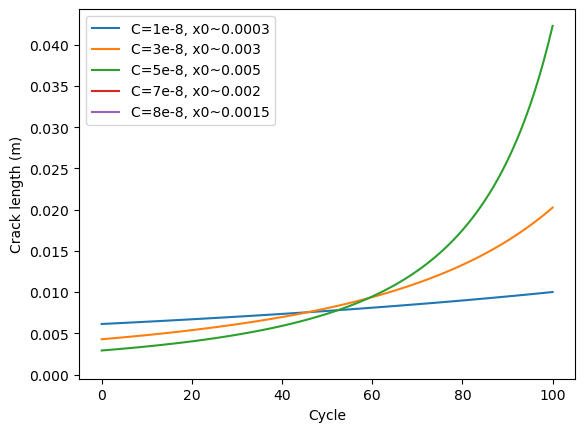

In [4]:
plt.plot(episodes1.max(0), label='C=1e-8, x0~0.0003')
plt.plot(episodes2.max(0), label='C=3e-8, x0~0.003')
plt.plot(episodes3.max(0), label='C=5e-8, x0~0.005')
plt.plot(episodes4.max(0), label='C=7e-8, x0~0.002')
plt.plot(episodes5.max(0), label='C=8e-8, x0~0.0015')
plt.xlabel('Cycle')
plt.ylabel('Crack length (m)')
plt.legend()
plt.show()

In [5]:
episodes.shape

(462366, 101)

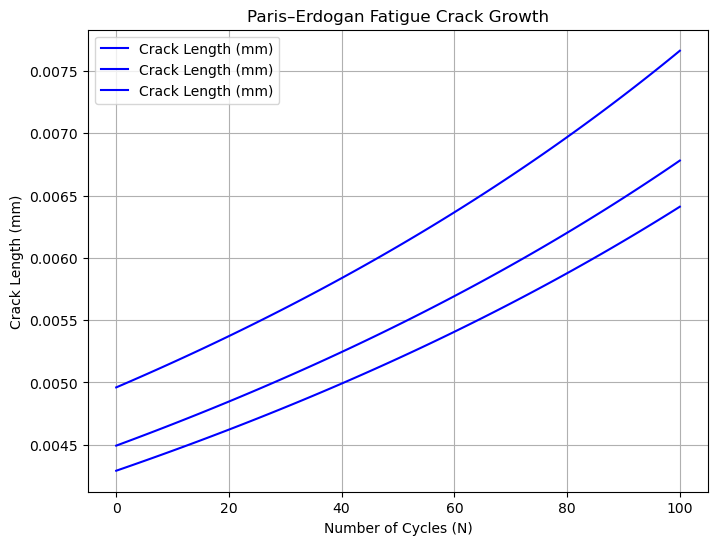

In [6]:

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(episodes[:3].T, 'b-', label='Crack Length (mm)')
plt.xlabel('Number of Cycles (N)')
plt.ylabel('Crack Length (mm)')
plt.title('Paris–Erdogan Fatigue Crack Growth')
plt.grid(True)
plt.legend()
plt.show()



In [7]:
# Normalize data
data = torch.tensor(episodes, dtype=torch.float32).to(device)
mean_data = torch.mean(data)
std_data = torch.std(data)

X = data[:,None,...] # shape N,C,L
# map min-max with shape N,C,L
X = (X - torch.min(X, 2)[0][...,None]) / (torch.max(X, 2)[0][...,None] - torch.min(X, 2)[0][...,None])
# X = (X - torch.mean(X, 2)[0][...,None]) / (torch.std(X, 2)[0][...,None])


In [8]:
X.shape

torch.Size([462366, 1, 101])

In [9]:
std_data

tensor(0.0025, device='mps:0')

In [10]:
X_std = torch.std(X)
X_std

tensor(0.2857, device='mps:0')

In [11]:
# -----------------------------
# 3.1 Define model (imported from src/degdiff/model_def.py)
# -----------------------------
from src.degdiff.model_def import TimeSeriesDiffusionModel

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model (choose TimeSeriesDiffusionModel or DegDiffusion)
model = TimeSeriesDiffusionModel(channels=X.shape[1]).to(device)
# model = DegDiffusion(channels=X.shape[1], sl=X.shape[2]).to(device)


In [12]:

# -----------------------------
# 4. Training loop
# -----------------------------
bs = 32
opt = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
s0_len = 50 # length of available signal

for epoch in range(50_000):
    idx = torch.randint(0, X.shape[0], (bs,))
    x0 = X[idx]
    t = torch.randint(0, model.T, (bs,)).to(device)
    noise = (torch.randn_like(x0)).to(device)
    xt = model.q_sample(x0, t, noise)
    s0 = x0[:,:,:s0_len] # available signal
    ns1 = xt[:,:,s0_len:] # noisy signal 
    noise1 = noise[:,:,s0_len:]
    noise0 = torch.zeros_like(s0).to(device)# no noise in available signal
    output_noise = torch.cat([noise0, noise1], dim=2)
    pred_noise = model(s0, ns1, t)
    loss = loss_fn(pred_noise, output_noise)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}")

Epoch 0, Loss 0.9104
Epoch 50, Loss 0.5128
Epoch 50, Loss 0.5128
Epoch 100, Loss 0.4847
Epoch 100, Loss 0.4847
Epoch 150, Loss 0.4885
Epoch 150, Loss 0.4885
Epoch 200, Loss 0.4811
Epoch 200, Loss 0.4811
Epoch 250, Loss 0.4390
Epoch 250, Loss 0.4390
Epoch 300, Loss 0.3918
Epoch 300, Loss 0.3918
Epoch 350, Loss 0.3378
Epoch 350, Loss 0.3378
Epoch 400, Loss 0.3643
Epoch 400, Loss 0.3643
Epoch 450, Loss 0.3069
Epoch 450, Loss 0.3069
Epoch 500, Loss 0.2769
Epoch 500, Loss 0.2769
Epoch 550, Loss 0.2632
Epoch 550, Loss 0.2632
Epoch 600, Loss 0.3291
Epoch 600, Loss 0.3291
Epoch 650, Loss 0.2939
Epoch 650, Loss 0.2939
Epoch 700, Loss 0.2841
Epoch 700, Loss 0.2841
Epoch 750, Loss 0.2928
Epoch 750, Loss 0.2928
Epoch 800, Loss 0.2768
Epoch 800, Loss 0.2768
Epoch 850, Loss 0.2640
Epoch 850, Loss 0.2640
Epoch 900, Loss 0.2749
Epoch 900, Loss 0.2749
Epoch 950, Loss 0.2305
Epoch 950, Loss 0.2305
Epoch 1000, Loss 0.2314
Epoch 1000, Loss 0.2314
Epoch 1050, Loss 0.2339
Epoch 1050, Loss 0.2339
Epoch 1100,

KeyboardInterrupt: 

In [13]:
s0.shape, ns1.shape

(torch.Size([32, 1, 50]), torch.Size([32, 1, 51]))

In [14]:
x0.shape, xt.shape, noise.shape, t.shape

(torch.Size([32, 1, 101]),
 torch.Size([32, 1, 101]),
 torch.Size([32, 1, 101]),
 torch.Size([32]))

In [16]:
synthetic = model.sample(x0, 50).detach().cpu().numpy()

In [17]:
synthetic.shape

(32, 1, 101)

In [18]:
x0.shape

torch.Size([32, 1, 101])

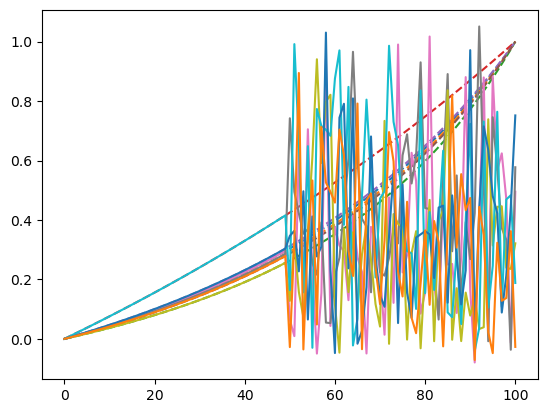

In [19]:
plt.plot(x0.squeeze().cpu()[:6, :].T, '--')
plt.plot(synthetic.squeeze()[:6, :].T, '-')


In [20]:
X.std([2]).shape

torch.Size([462366, 1])

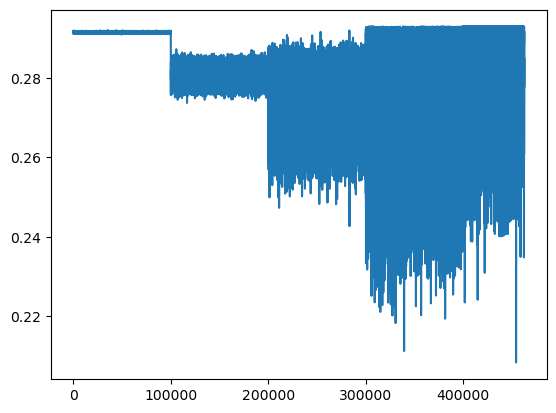

In [21]:
plt.plot(X.std([2]).cpu())

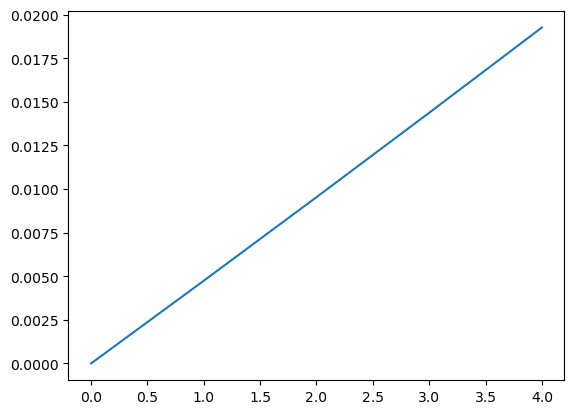

In [22]:
plt.plot(synthetic.squeeze()[:,:5].mean(0))